Train full: (75158, 21) | Test: (23459, 21)
Train sub: (62786, 21) | Valid: (12372, 21)

XGBoost (native, early-stopped on validation) — Test results:
MAE: 9.62
RMSE: 53.75
R²: 0.938

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 61.69
RMSE: 99.62
R²: 0.786


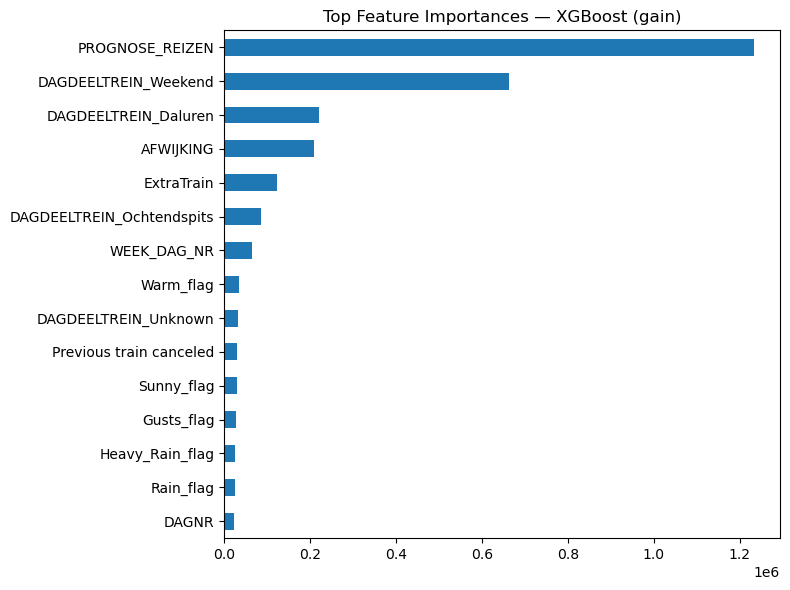

In [8]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# --- 2) Load data (safer read: low_memory=False; explicit na_values) ---
df = pd.read_csv(r"C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\complete_dataset_clean_vf.csv",
    sep=";",
    low_memory=False,
    na_values=["", "NA", "NaN", "NULL"]
)


# --- target and features ---
y = df["REALISATIE"]

base_features = [
    "DAGNR", "WEEK_DAG_NR","DAGDEELTREIN","PROGNOSE_REIZEN","AFWIJKING"]

weather_features = [c for c in ["Rain_flag","Heavy_Rain_flag","Gusts_flag", "Storms_flag", "Warm_flag", "Cold_flag", "Sunny_flag"] if c in df.columns]
disrupt_features = [c for c in ["Cancelled","ExtraTrain","delay","Disruption (minutes)","Previous train canceled","Previous train delayed"] if c in df.columns]

# keep only features that exist in df
features = [c for c in (base_features + weather_features + disrupt_features) if c in df.columns]
X = df[features].copy()

# one-hot encode categoricals
categorical_cols = [c for c in ["DAGDEELTREIN"] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4) Chronological split ---
cutoff_day = df["DAGNR"].max() - 7          # last 7 days as test
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test       = X[test_mask]
y_test       = y[test_mask]

print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

# --- 5) Validation split inside training (chronological) ---
train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

if len(tr_days) == 0:   # fallback if tiny
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
X_va, y_va = X[valid_mask],     y[valid_mask]

print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

# --- 6) XGBoost (native API) with early stopping on validation ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42
}

# Build DMatrices (pass feature names so importance lines up)
feature_names = list(X.columns)
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test, feature_names=feature_names)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=200,
    verbose_eval=False
)

# --- 7) Evaluate on TEST set ---
y_pred = bst.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nXGBoost (native, early-stopped on validation) — Test results:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))

# --- Operator baseline ---
if "PROGNOSE_REIZEN" in df.columns:
    op_pred  = df.loc[test_mask, "PROGNOSE_REIZEN"]
    op_mae   = mean_absolute_error(y_test, op_pred)
    op_rmse  = np.sqrt(mean_squared_error(y_test, op_pred))
    op_r2    = r2_score(y_test, op_pred)

    print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
    print("MAE:", round(op_mae, 2))
    print("RMSE:", round(op_rmse, 2))
    print("R²:", round(op_r2, 3))

# --- 8) Feature importance (gain) ---
score_dict = bst.get_score(importance_type="gain")
fi = pd.Series({f: score_dict.get(f, 0.0) for f in feature_names}).sort_values(ascending=True).tail(15)
fi.plot(kind="barh", figsize=(8,6))
plt.title("Top Feature Importances — XGBoost (gain)")
plt.tight_layout()
plt.show()


Train full: (24564, 20) | Test: (7724, 20)
Train sub: (20634, 20) | Valid: (3930, 20)

XGBoost (native, early-stopped on validation) — Test results:
MAE: 4.4
RMSE: 10.29
R²: 0.998

Operator Forecast (PROGNOSE_REIZEN) — Test results:
MAE: 71.13
RMSE: 113.07
R²: 0.767


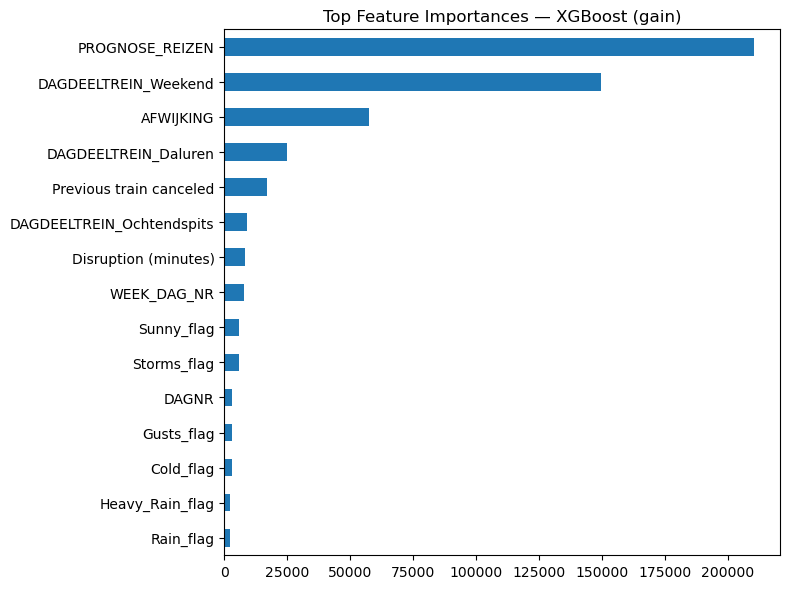

In [7]:
# --- 1) Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

# --- 2) Load data (safer read: low_memory=False; explicit na_values) ---
df = pd.read_csv(r"C:\Users\Alejandro Fiatt\Documents\GitHub\Group2_NS\complete_dataset_clean_delaysonly_vf.csv",
    sep=";",
    low_memory=False,
    na_values=["", "NA", "NaN", "NULL"]
)


# --- target and features ---
y = df["REALISATIE"]

base_features = [
    "DAGNR", "WEEK_DAG_NR","DAGDEELTREIN","PROGNOSE_REIZEN","AFWIJKING"]

weather_features = [c for c in ["Rain_flag","Heavy_Rain_flag","Gusts_flag", "Storms_flag", "Warm_flag", "Cold_flag", "Sunny_flag"] if c in df.columns]
disrupt_features = [c for c in ["Cancelled","ExtraTrain","delay","Disruption (minutes)","Previous train canceled","Previous train delayed"] if c in df.columns]

# keep only features that exist in df
features = [c for c in (base_features + weather_features + disrupt_features) if c in df.columns]
X = df[features].copy()

# one-hot encode categoricals
categorical_cols = [c for c in ["DAGDEELTREIN"] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- 4) Chronological split ---
cutoff_day = df["DAGNR"].max() - 7          # last 7 days as test
train_mask = df["DAGNR"] <= cutoff_day
test_mask  = df["DAGNR"] >  cutoff_day

X_train_full = X[train_mask]
y_train_full = y[train_mask]
X_test       = X[test_mask]
y_test       = y[test_mask]

print("Train full:", X_train_full.shape, "| Test:", X_test.shape)

# --- 5) Validation split inside training (chronological) ---
train_days = np.sort(df.loc[train_mask, "DAGNR"].unique())
val_days_count = max(1, int(0.2 * len(train_days)))  # ~20% of training days
val_days = set(train_days[-val_days_count:])
tr_days  = set(train_days[:-val_days_count]) if val_days_count < len(train_days) else set()

if len(tr_days) == 0:   # fallback if tiny
    val_days = set(train_days[-2:])
    tr_days  = set(train_days[:-2])

train_sub_mask = train_mask & df["DAGNR"].isin(tr_days)
valid_mask     = train_mask & df["DAGNR"].isin(val_days)

X_tr, y_tr = X[train_sub_mask], y[train_sub_mask]
X_va, y_va = X[valid_mask],     y[valid_mask]

print("Train sub:", X_tr.shape, "| Valid:", X_va.shape)

# --- 6) XGBoost (native API) with early stopping on validation ---
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "seed": 42
}

# Build DMatrices (pass feature names so importance lines up)
feature_names = list(X.columns)
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names)
dtest  = xgb.DMatrix(X_test, feature_names=feature_names)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=200,
    verbose_eval=False
)

# --- 7) Evaluate on TEST set ---
y_pred = bst.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nXGBoost (native, early-stopped on validation) — Test results:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 3))

# --- Operator baseline ---
if "PROGNOSE_REIZEN" in df.columns:
    op_pred  = df.loc[test_mask, "PROGNOSE_REIZEN"]
    op_mae   = mean_absolute_error(y_test, op_pred)
    op_rmse  = np.sqrt(mean_squared_error(y_test, op_pred))
    op_r2    = r2_score(y_test, op_pred)

    print("\nOperator Forecast (PROGNOSE_REIZEN) — Test results:")
    print("MAE:", round(op_mae, 2))
    print("RMSE:", round(op_rmse, 2))
    print("R²:", round(op_r2, 3))

# --- 8) Feature importance (gain) ---
score_dict = bst.get_score(importance_type="gain")
fi = pd.Series({f: score_dict.get(f, 0.0) for f in feature_names}).sort_values(ascending=True).tail(15)
fi.plot(kind="barh", figsize=(8,6))
plt.title("Top Feature Importances — XGBoost (gain)")
plt.tight_layout()
plt.show()
